In [43]:
import openeo
from matplotlib import pyplot as plt
import rasterio.plot
import io
import tarfile
import numpy as np
import glob
import re
import os
import xarray as xr
import torch
import functions.handy_functions as hf
import functions.parse_data as parse
import pandas as pd

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [44]:
main_dir='/cloud/skogsstyrelsen_pairs_clear_2/'
directories=os.listdir(main_dir)
#directories

In [45]:
sun_zenith_np=np.array([48.10258555, 46.62837522, 47.6459767 , 31.83072945,
                        33.69190491, 35.67351442, 46.42774732, 37.15326461, 41.34795651,
                        47.11931233, 47.08281932, 29.37867897, 31.23052966, 26.21048804,
                        26.99746596, 51.1544963 , 50.2538547 , 53.23794325, 52.70034371,
                        44.14381837, 48.3205705 , 50.30765058, 48.71353692, 36.1154744 ,
                        36.98005634, 32.56612326, 33.45330837, 37.14737277, 37.95840042,
                        41.20877219, 41.14310695, 46.16254884, 45.40657544, 37.27761812,
                        42.17245033, 52.12410723, 51.59146449, 43.93344343, 49.41213256])

In [46]:
ims_all=[]
temporals_all=[]
dataset_all=[]
for dir in directories:
    data_clear=xr.load_dataset(main_dir+dir+'/clear_data.nc', engine='netcdf4', decode_times=True)
    data_cloudy=xr.load_dataset(main_dir+dir+'/cloudy_data.nc', engine='netcdf4', decode_times=True)

    variables=data_clear.variables

    ## Get bands ##
    b02=variables['b02'].data
    b03=variables['b03'].data
    b04=variables['b04'].data
    b05=variables['b05'].data
    b06=variables['b06'].data
    b07=variables['b07'].data
    b08=variables['b08'].data
    b8a=variables['b8a'].data
    b09=variables['b09'].data
    b10=variables['b10'].data
    b11=variables['b11'].data
    b12=variables['b12'].data
    sun_z=variables['sun_zenith_angle'].data
    c_mask=variables['cloud_mask'].data

    ## Save image ##
    im_clear=np.zeros((np.shape(b03)[0],np.shape(b03)[1],14))
    im_clear[:,:,0]=b02
    im_clear[:,:,1]=b03
    im_clear[:,:,2]=b04
    im_clear[:,:,3]=b05
    im_clear[:,:,4]=b06
    im_clear[:,:,5]=b07
    im_clear[:,:,6]=b08
    im_clear[:,:,7]=b8a
    im_clear[:,:,8]=b09
    im_clear[:,:,9]=b10
    im_clear[:,:,10]=b11
    im_clear[:,:,11]=b12
    im_clear[:,:,12]=sun_z
    im_clear[:,:,13]=c_mask

    variables=data_cloudy.variables

    ## Get bands ##
    b02=variables['b02'].data
    b03=variables['b03'].data
    b04=variables['b04'].data
    b05=variables['b05'].data
    b06=variables['b06'].data
    b07=variables['b07'].data
    b08=variables['b08'].data
    b8a=variables['b8a'].data
    b09=variables['b09'].data
    b10=variables['b10'].data
    b11=variables['b11'].data
    b12=variables['b12'].data
    sun_z=variables['sun_zenith_angle'].data
    cot=variables['cloud_mask'].data

    ## Save image ##
    im_cloudy=np.zeros((np.shape(b03)[0],np.shape(b03)[1],14))
    im_cloudy[:,:,0]=b02
    im_cloudy[:,:,1]=b03
    im_cloudy[:,:,2]=b04
    im_cloudy[:,:,3]=b05
    im_cloudy[:,:,4]=b06
    im_cloudy[:,:,5]=b07
    im_cloudy[:,:,6]=b08
    im_cloudy[:,:,7]=b8a
    im_cloudy[:,:,8]=b09
    im_cloudy[:,:,9]=b10
    im_cloudy[:,:,10]=b11
    im_cloudy[:,:,11]=b12
    im_cloudy[:,:,12]=sun_z
    im_cloudy[:,:,13]=cot

    t_is_cloud = 0.025*50 # From Alex
    t_thin_cloud = 0.015*50 # From Alex
    im_shape=np.shape(im_cloudy)
    c_mask=cot
    c_mask=np.reshape(c_mask,im_shape[0]*im_shape[1])
    c_mask[c_mask<t_thin_cloud]=0
    c_mask[(c_mask>t_thin_cloud)&(c_mask<t_is_cloud)]=1
    c_mask[c_mask>t_is_cloud]=2
    c_mask=np.reshape(c_mask,(im_shape[0],im_shape[1]))

    im_cloudy_cmask=np.zeros((im_shape[0],im_shape[1],im_shape[2]+1))
    im_cloudy_cmask[:,:,0:14]=im_cloudy
    im_cloudy_cmask[:,:,-1]=c_mask

    im_pair=[im_clear,im_cloudy_cmask]
    ims_all.append(im_pair)
    temporals_all.append([data_clear.coords['t'].data[0],data_cloudy.coords['t'].data[0]])
    dataset_all.append([data_clear,data_cloudy])

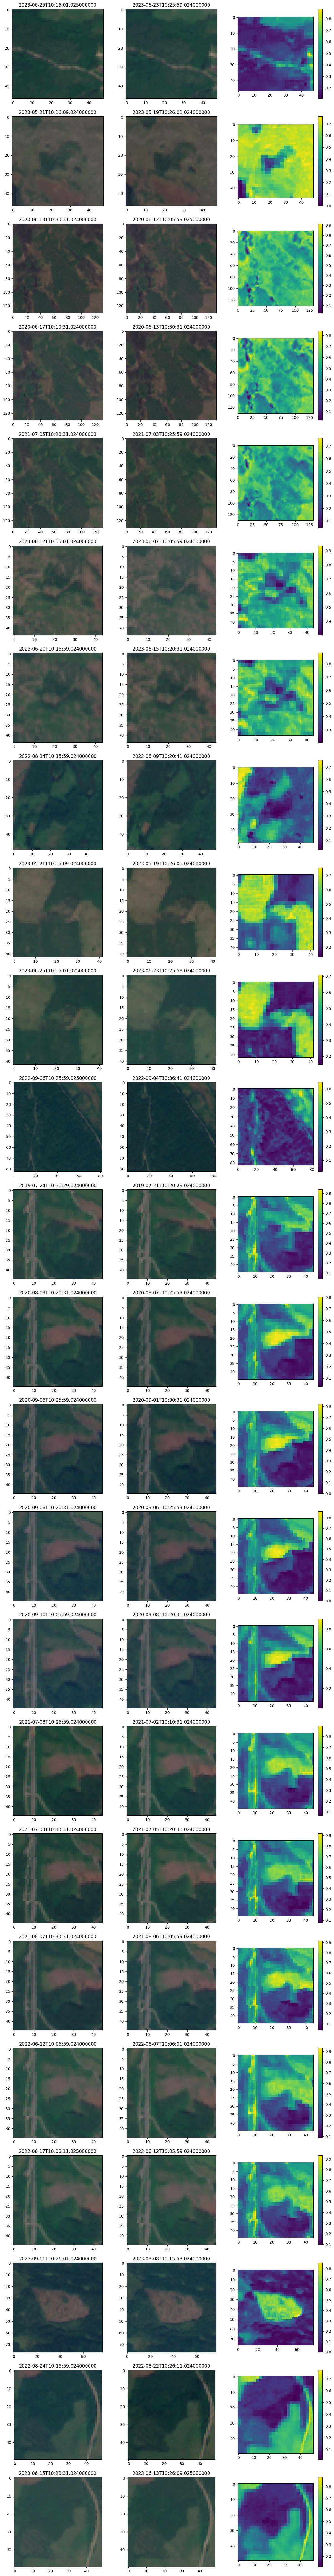

In [47]:
ncols=3
nrows=len(ims_all)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,pair in enumerate(ims_all):

    im_clear=pair[0]
    im_cloud=pair[1]

    im_clear_show=hf.Sentinel2TrueColor(im_clear)
    im_cloud_show=hf.Sentinel2TrueColor(im_cloud)

    axs[pair_c,0].imshow(im_clear_show)
    axs[pair_c,0].set_title(temporals_all[i][0])
    axs[pair_c,1].imshow(im_cloud_show)
    axs[pair_c,1].set_title(temporals_all[i][1])
    im_c=axs[pair_c,2].imshow(im_cloud[:,:,-2])
    fig.colorbar(im_c,ax=axs[pair_c,2])
    pair_c+=1

In [48]:
len(ims_all)

24

In [49]:
main_filepath='pytorch_models/final_model_shadow_edition_10ens_trans'
n_ensemble=10
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))
    
index_median=1

In [50]:
preds_all=[]
uncertainties_all=[]
for i,pair in enumerate(ims_all):
    im_cloud=pair[1]

    ## Reshape cloudy data
    im_shape=np.shape(im_cloud)
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    im_pred_cot_t_r=im_cloud_r[:,-1]
    #One hot encode cot
    cot_one_hot=np.zeros((len(im_pred_cot_t_r),3))
    cot_one_hot[im_pred_cot_t_r==0,0]=1
    cot_one_hot[im_pred_cot_t_r==1,1]=1
    cot_one_hot[im_pred_cot_t_r==2,2]=1

    ## append cot estimation to input data ##
    im_cloud_r_c=np.zeros((np.shape(im_cloud_r)[0],np.shape(im_cloud_r)[1]+3))
    im_cloud_r_c[:,0:14]=im_cloud_r[:,0:14]
    im_cloud_r_c[:,15:19]=cot_one_hot

    ## Make prediction
    for i,model in enumerate(models):
        if i==0:
            pred=model.predict(im_cloud_r_c[:,0:13])
        else:   
            pred=pred+model.predict(im_cloud_r_c[:,0:13])
    pred=pred/len(models)

    ##Reshape back
    im_shape_pred=(im_shape[0],im_shape[1],12)
    im_pred=np.zeros(im_shape_pred)
    im_unc=np.zeros(im_shape_pred)
    for i in range(im_shape_pred[2]):
        im_pred[:,:,i]=np.reshape(pred[:,i,index_median],im_shape_pred[0:2])
        im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape_pred[0:2])

    preds_all.append(im_pred)
    uncertainties_all.append(im_unc)

## Temporal Bias in image pairs

In [51]:
which_pair=0 #5, 12
im_cloud=ims_all[which_pair][1]
im_clear=ims_all[which_pair][0]
im_pred=preds_all[which_pair]

In [52]:
im_cloud_show=hf.Sentinel2TrueColor(im_cloud)
im_clear_show=hf.Sentinel2TrueColor(im_clear)
im_pred_show=hf.Sentinel2TrueColor(im_pred)

Text(0.5, 1.0, '2023-06-23T10:25:59.024000000')

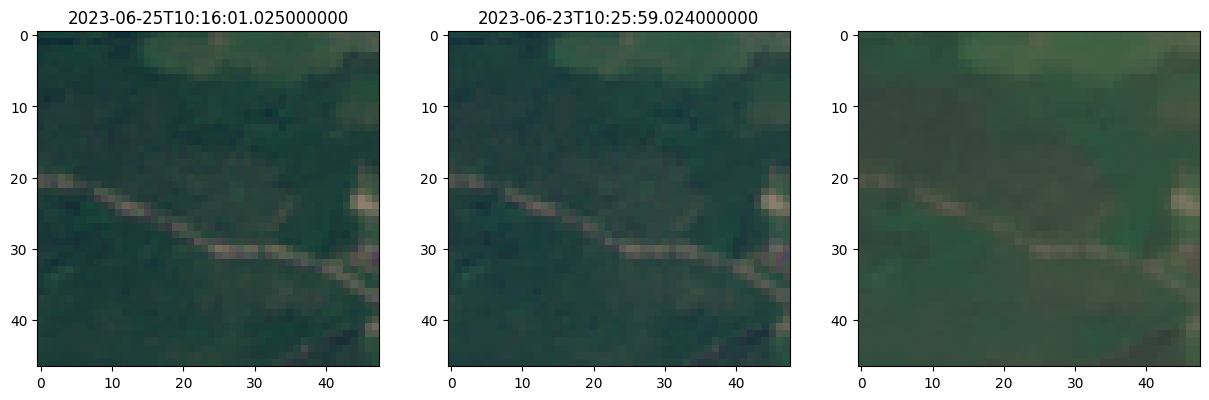

In [53]:
plt.rcParams["figure.figsize"] = [15, 5]
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(im_clear_show)
axs[1].imshow(im_cloud_show)
axs[2].imshow(im_pred_show)

axs[0].set_title(temporals_all[which_pair][0])
axs[1].set_title(temporals_all[which_pair][1])

In [54]:
#clear_2
bound_box=np.array([[0,30,40,10,20],
                     [1,0,10,20,30],
                     [2,60,80,60,80],
                     [3,60,80,60,80],
                     [4,60,80,60,80],
                     [5,30,40,20,30],
                     [6,30,40,20,30],
                     [7,35,45,30,45],
                     [8,30,40,15,30],
                     [9,30,40,15,30],
                     [10,50,70,40,60],
                     [11,35,45,30,40],
                     [12,35,45,30,40],
                     [13,35,45,30,40],
                     [14,35,45,30,40]])
"""
 # For clear_1
bound_box=np.array([
                   [0,60,90,60,90],
                    [2,25,35,15,25],
                    [3,35,45,30,40],
                    [3,25,30,15,25],
                    [4,20,40,25,45],
                    [4,60,80,40,60],
                    [5,32,42,30,40],
                    [6,32,42,30,40],
                    [7,32,42,30,40],
                    [9,60,70,40,60],
                    [10,60,70,40,60],
                    [11,10,20,15,25],
                    [12,0,20,0,10],
                    [1,60,80,60,80]
                    ])#image index, y1,y2,x1,x2
"""

specs_clear=np.zeros((len(bound_box),12))
specs_cloud=np.zeros((len(bound_box),12))
time_diff=np.zeros(len(bound_box))
nmses=np.zeros((len(bound_box),12))

for i,box in enumerate(bound_box):
    im_pair=ims_all[box[0]]
    im_clear=im_pair[0]
    im_cloud=im_pair[1]
    temporal_pair=temporals_all[box[0]]   
    time_diff[i]=int(np.abs(int(str(temporal_pair[0]).split('-')[2].split('T')[0])-int(str(temporal_pair[1]).split('-')[2].split('T')[0])))
    im_clear_box=im_clear[box[1]:box[2],box[3]:box[4],:]
    im_cloud_box=im_cloud[box[1]:box[2],box[3]:box[4],:]

    specs_clear[i,:]=np.mean(im_clear_box,axis=(0,1))[:12]
    specs_cloud[i,:]=np.mean(im_cloud_box,axis=(0,1))[:12] 

    norm_temp=np.linalg.norm((im_clear_box[:,:,0:12])-im_cloud_box[:,:,0:12],axis=(0,1))**2
    norm_gt=np.linalg.norm(im_clear_box[:,:,0:12],axis=(0,1))**2

    NMSE_temp=norm_temp/norm_gt
    nmses[i,:]=NMSE_temp


In [67]:
np.round(np.mean(nmses,axis=0),4)

array([0.0024, 0.0034, 0.0052, 0.0049, 0.0066, 0.0059, 0.0099, 0.0056,
       0.1421, 1.2973, 0.0081, 0.0113])

In [56]:
channels=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12']

In [57]:
np.min(time_diff)

1.0

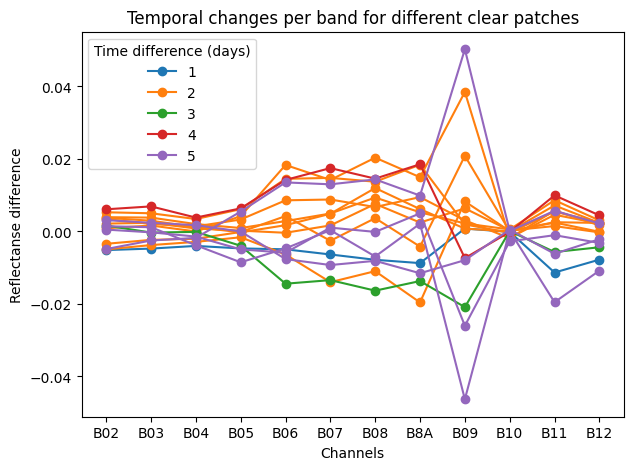

In [58]:
plt.rcParams["figure.figsize"] = [7, 5]
colors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
fig, ax=plt.subplots()
axes=[]
for i in range(5):
    mask=(time_diff==(i+1))
    axes.append(ax.plot(channels,(specs_clear[mask]-specs_cloud[mask]).T,'-o',color=colors[i],label=i+1))
#plt.plot(channels,np.mean(clear_array_c[:,:12],axis=0),'--o')
ax.set_xlabel("Channels")
ax.set_ylabel("Reflectanse difference")
ax.set_title("Temporal changes per band for different clear patches")
ax.legend([axes[0][0],axes[1][0],axes[2][0],axes[3][0],axes[4][0]],['1','2','3','4','5'],title='Time difference (days)')

In [59]:
np.mean(np.abs(specs_clear-specs_cloud),axis=0)

array([0.00337578, 0.00281569, 0.00203117, 0.00338381, 0.00815126,
       0.0084544 , 0.01017328, 0.01000448, 0.01610331, 0.00059376,
       0.00650476, 0.00328828])

In [60]:
np.abs(specs_clear-specs_cloud)

array([[3.40400000e-03, 2.32100000e-03, 2.01400000e-03, 1.44000000e-04,
        4.24000000e-03, 2.58000000e-03, 3.66800000e-03, 4.18000000e-03,
        2.08680000e-02, 4.00000000e-05, 7.18000000e-03, 2.34400000e-03],
       [3.94000000e-03, 3.82800000e-03, 2.03700000e-03, 9.50000000e-04,
        2.86200000e-03, 4.95000000e-03, 9.36000000e-03, 5.29400000e-03,
        2.21000000e-03, 5.50000000e-04, 8.62600000e-03, 3.04600000e-03],
       [5.13725000e-03, 4.72275000e-03, 3.98800000e-03, 4.67675000e-03,
        4.92400000e-03, 6.34775000e-03, 7.81775000e-03, 8.73250000e-03,
        8.07250000e-04, 1.18500000e-04, 1.13302500e-02, 7.77350000e-03],
       [6.11575000e-03, 6.91675000e-03, 3.83125000e-03, 6.36300000e-03,
        1.42200000e-02, 1.74792500e-02, 1.45730000e-02, 1.85435000e-02,
        7.35650000e-03, 1.31000000e-04, 9.96000000e-03, 4.44775000e-03],
       [3.42600000e-03, 2.07600000e-03, 1.39900000e-03, 3.29675000e-03,
        8.59150000e-03, 8.81500000e-03, 6.74150000e-03, 9.47

In [61]:
which_pair=2 #5, 12
im_cloud=ims_all[which_pair][1]
im_clear=ims_all[which_pair][0]
im_pred=preds_all[which_pair]

In [62]:
im_cloud_show=hf.Sentinel2TrueColor(im_cloud)
im_clear_show=hf.Sentinel2TrueColor(im_clear)
im_pred_show=hf.Sentinel2TrueColor(im_pred)

Text(0.5, 0.98, 'Example bounding box for temporal change analysis')

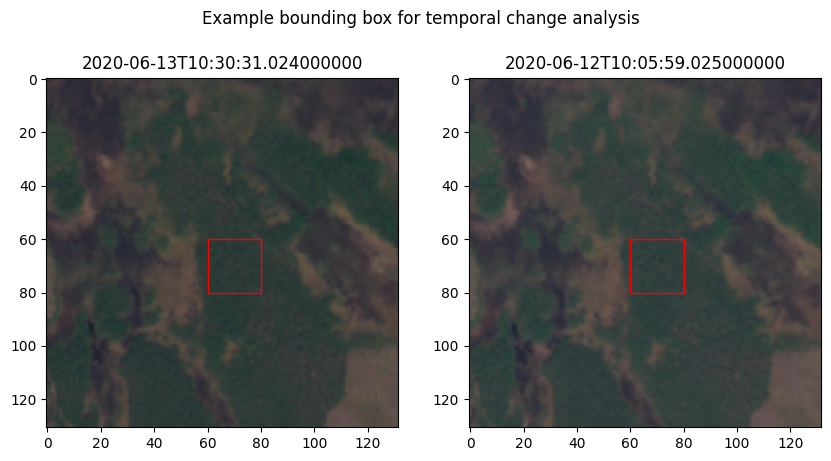

In [63]:
import matplotlib.patches as patches 
box=[60,80,60,80]
rect=patches.Rectangle((box[2],box[0]),box[3]-box[2],box[1]-box[0], edgecolor='r',facecolor='none')
rect_2=patches.Rectangle((box[2],box[0]),box[3]-box[2],box[1]-box[0], edgecolor='r',facecolor='none')

plt.rcParams["figure.figsize"] = [10, 5]
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0].imshow(im_clear_show)
axs[0].add_patch(rect)
axs[1].imshow(im_cloud_show)
axs[1].add_patch(rect_2)

axs[0].set_title(temporals_all[which_pair][0])
axs[1].set_title(temporals_all[which_pair][1])
fig.suptitle("Example bounding box for temporal change analysis")